*Import Packages*

In [1]:
import os
import pandas as pd
import numpy as np
import phyaat as ph
import mne
import matplotlib.pyplot as plt

from scipy.signal import medfilt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix, accuracy_score

from mne.baseline import rescale
from mne.stats import bootstrap_confidence_interval
from mne.time_frequency import tfr_morlet, psd_welch
from mne_features.feature_extraction import FeatureExtractor
from mne_features.feature_extraction import extract_features
%matplotlib inline

PhyAAt Processing lib Loaded...


*Downloading data*

In [2]:
# For all the subjects use subject =-1 or for specify subject use there number e.g.subject=10 for 10th Subject
dirPath = ph.download_data(baseDir='../PhyAAt_Data', subject=1,verbose=0,overwrite=False)

In [3]:
baseDir='../PhyAAt_Data'
SubID = ph.ReadFilesPath(baseDir) 
#check files of subject=1
SubID[1]

Total Subjects :  25


{'sigFile': '../PhyAAt_Data/phyaat_dataset/Signals/S1/S1_Signals.csv',
 'txtFile': '../PhyAAt_Data/phyaat_dataset/Signals/S1/S1_Textscore.csv'}

In [4]:
# Create a Subj to hold the data
Subj = ph.Subject(SubID[1])

In [5]:
dataframe = pd.read_csv('sub1.csv') 
dataframe.loc[
    :,
    dataframe.columns[:-1]
] *= 1e-6
data1 = dataframe.transpose().to_numpy()

n_channels = len(dataframe.columns)    
sampling_freq = 128  # Sampling frequency
info = mne.create_info(n_channels, sfreq=sampling_freq)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
 chs: 15 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 15
 projs: []
 sfreq: 128.0 Hz
>


In [6]:
ch_names = ['AF3','F7','F3','FC5','T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4','label']
ch_types = ['eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg','stim']
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info.set_montage('standard_1020')

<Info | 8 non-empty values
 bads: []
 ch_names: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4, label
 chs: 14 EEG, 1 Stimulus
 custom_ref_applied: False
 dig: 17 items (3 Cardinal, 14 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 15
 projs: []
 sfreq: 128.0 Hz
>

In [7]:
raw = mne.io.RawArray(data1, info)  
raw.info

Creating RawArray with float64 data, n_channels=15, n_times=277548
    Range : 0 ... 277547 =      0.000 ...  2168.336 secs
Ready.


<Info | 8 non-empty values
 bads: []
 ch_names: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4, label
 chs: 14 EEG, 1 Stimulus
 custom_ref_applied: False
 dig: 17 items (3 Cardinal, 14 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 15
 projs: []
 sfreq: 128.0 Hz
>

Using matplotlib as 2D backend.


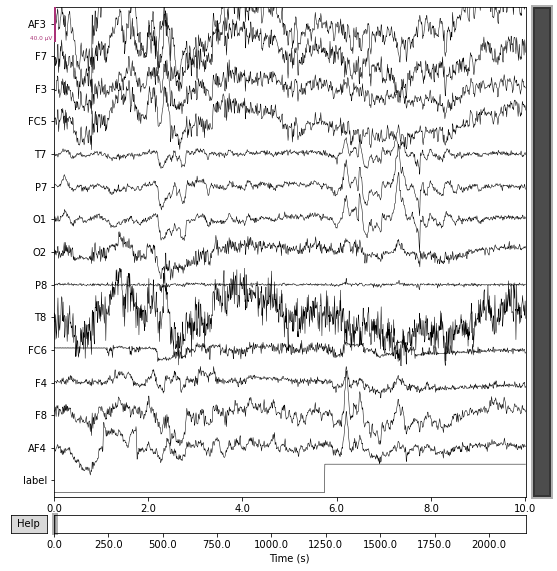

In [8]:
mne.set_config('MNE_BROWSE_RAW_SIZE','8,8')  
raw.plot();

In [9]:
# Filter version of both mne and pyhaat
Subj.filter_EEG(band =[0.5],btype='highpass',order=5)
raw.filter(1,20)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.2s finished


<RawArray | 15 x 277548 (2168.3 s), ~31.8 MB, data loaded>

In [10]:
plt.rcParams["figure.figsize"]=20,10

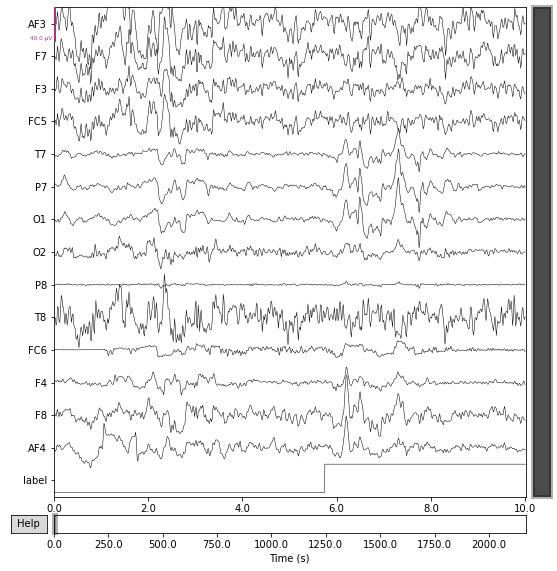

In [11]:
raw.plot();

In [12]:
#Extracting Raw Signal
raw_eeg = Subj.getEEG().to_numpy()
raw_gsr = Subj.getGSR().to_numpy()
raw_ppg = Subj.getPPG().to_numpy()

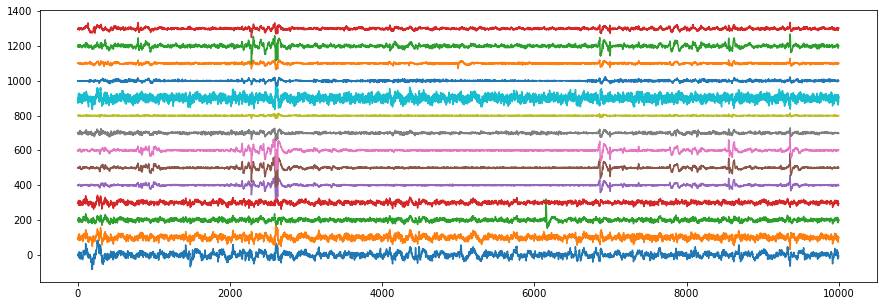

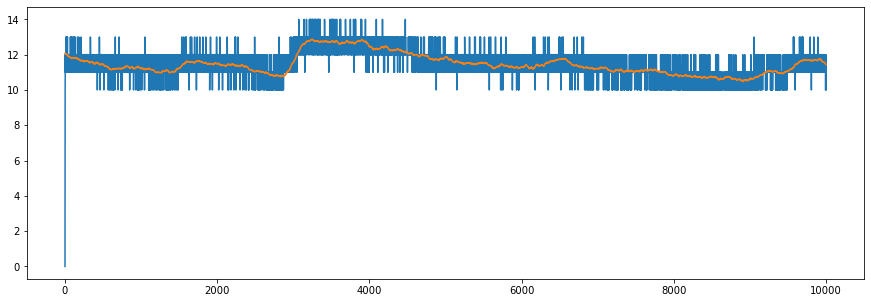

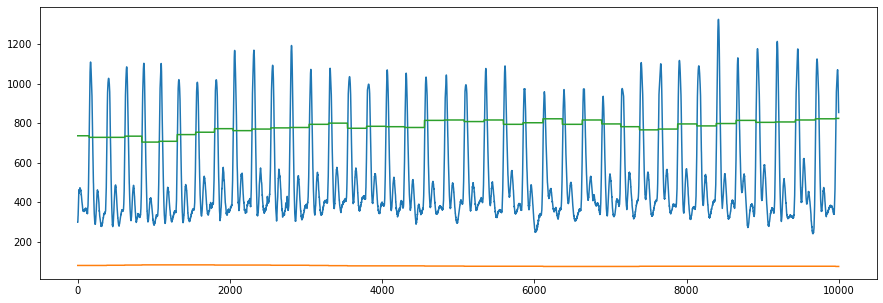

In [13]:
#Plotting raw signals
plt.figure(figsize=(15,5))
plt.plot(raw_eeg[:10000,:]+np.arange(14)*100)
plt.show()
plt.figure(figsize=(15,5))
plt.plot(raw_gsr[:10000,:])
plt.show()
plt.figure(figsize=(15,5))
plt.plot(raw_ppg[:10000,:])
plt.show()

In [14]:
# Performing ICA to remove artifacts using both phyaat and mne
# setting window size to 1280 (10sec), which is larg, but takes less time
Subj.correct(method='ICA',verbose=1,winsize=128*10) 

ICA Artifact Removal : extended-infomax
100%|####################################################################################################|


In [15]:
ica = mne.preprocessing.ICA(n_components=14, random_state=0)

In [16]:
ica.fit(raw.copy().filter(8,35))

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 213 samples (1.664 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Fitting ICA to data using 14 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished


Selecting by number: 14 components
Fitting ICA took 5.5s.


Method,fastica
Fit,42 iterations on raw data (277548 samples)
ICA components,14
Explained variance,100.0 %
Available PCA components,14
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=14, n_times=277548
    Range : 0 ... 277547 =      0.000 ...  2168.336 secs
Ready.


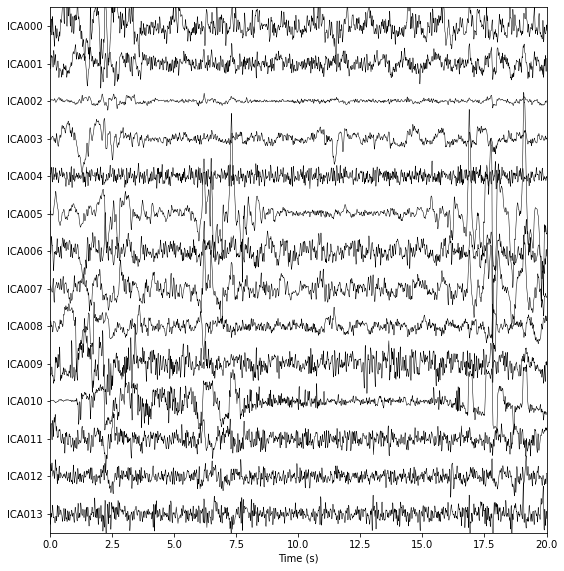

In [17]:
ica.plot_sources(raw, show_scrollbars=False);

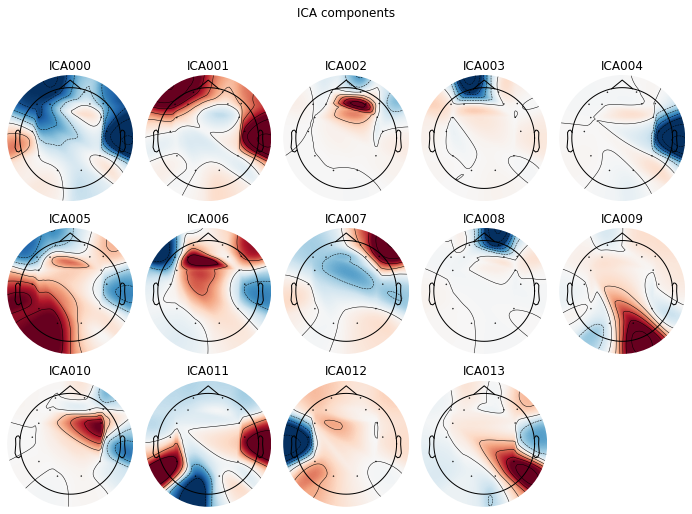

[<MNEFigure size 702x526.68 with 14 Axes>]

In [18]:
ica.plot_components(outlines="skirt")

Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components


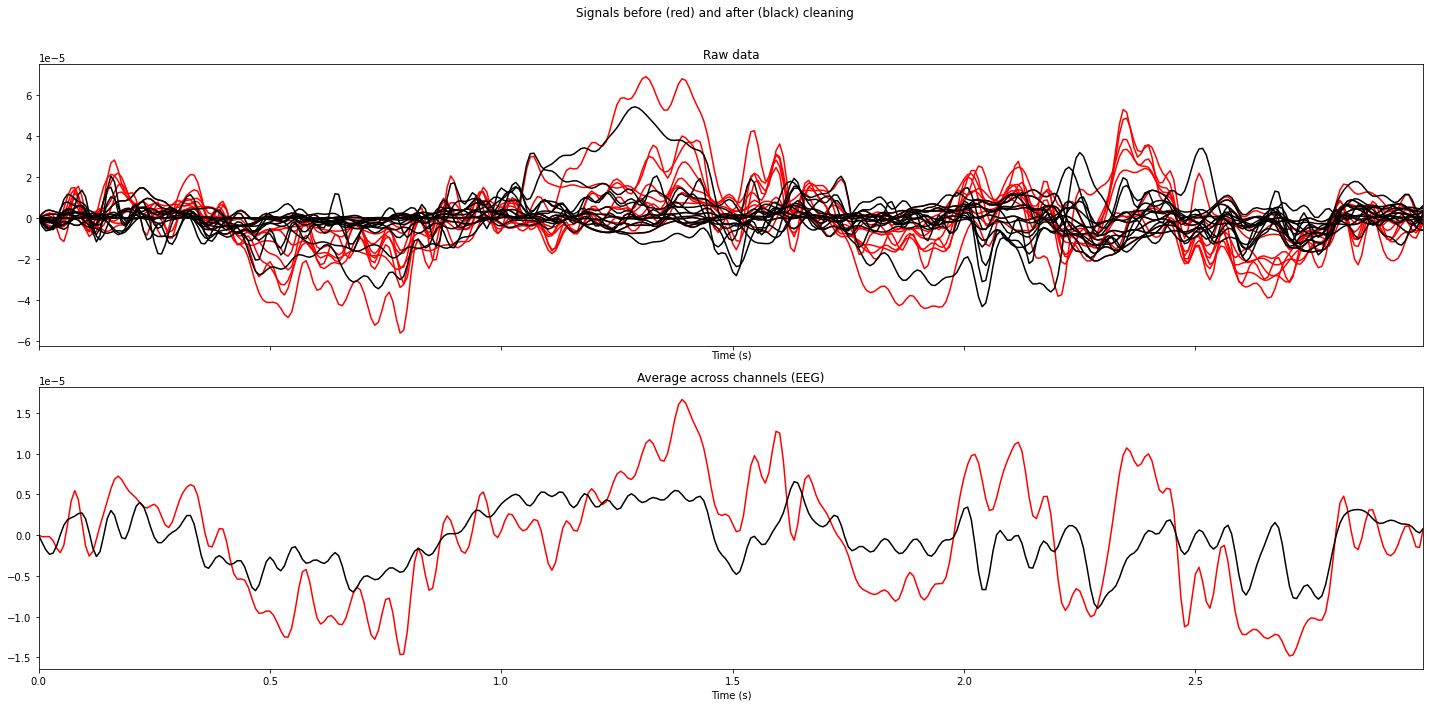

In [19]:
ica.plot_overlay(raw, exclude=[0], picks='eeg');

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1084 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1084 matching events found
No baseline correction applied
0 projection items activated


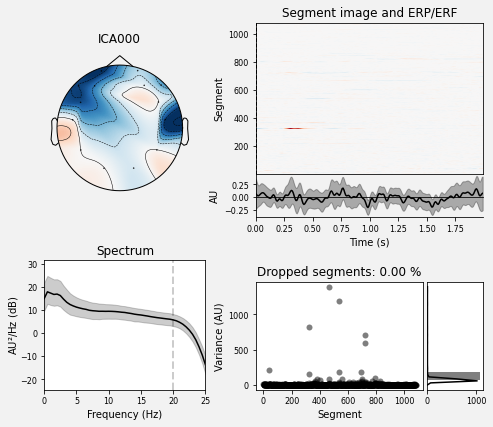

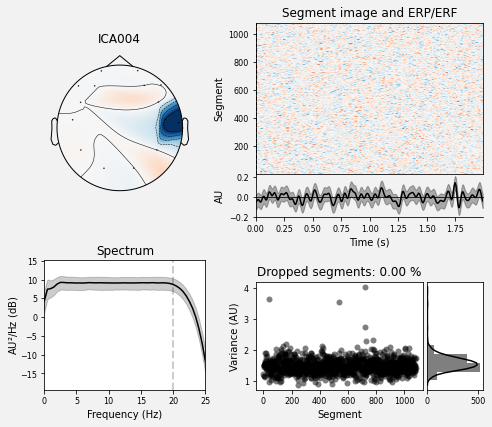

In [20]:
ica.plot_properties(raw, picks=[0, 4]);

In [21]:
ica.exclude = [3, 8]

In [22]:
bad_idx, scores = ica.find_bads_eog(raw, 'P8', threshold=2)
print(bad_idx)

Using EOG channel: P8
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 sec)

[5, 13]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


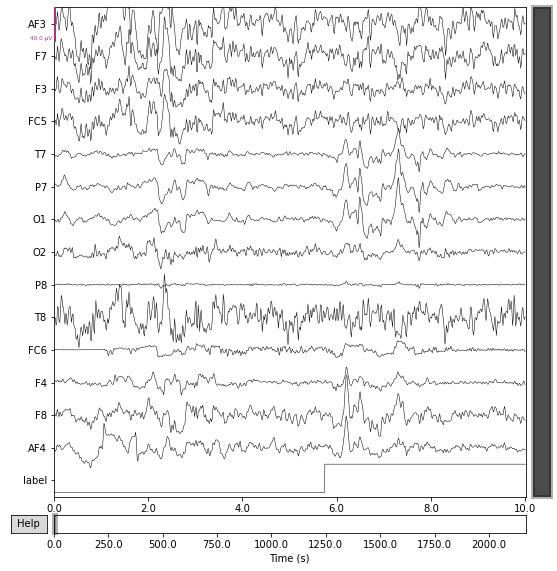

In [23]:
raw.plot();

Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 2 ICA components
    Projecting back using 14 PCA components


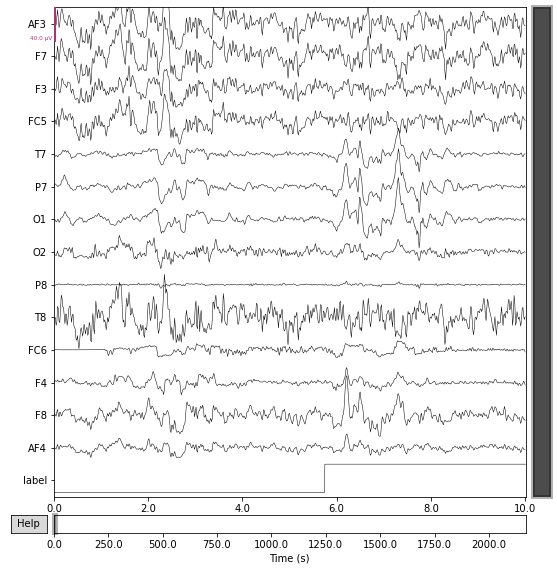

In [24]:
ica.apply(raw.copy(), exclude=ica.exclude).plot();

In [25]:
events = mne.find_events(raw,consecutive=True,initial_event=True)
event_ids = {"target/listening":1, "standard/writing":2,"resting":3}

429 events found
Event IDs: [1 2 3]


In [26]:
events

array([[   736,      0,      1],
       [  1656,      1,      2],
       [  4220,      2,      3],
       ...,
       [276132,      3,      1],
       [276416,      1,      2],
       [277312,      2,      3]], dtype=int64)

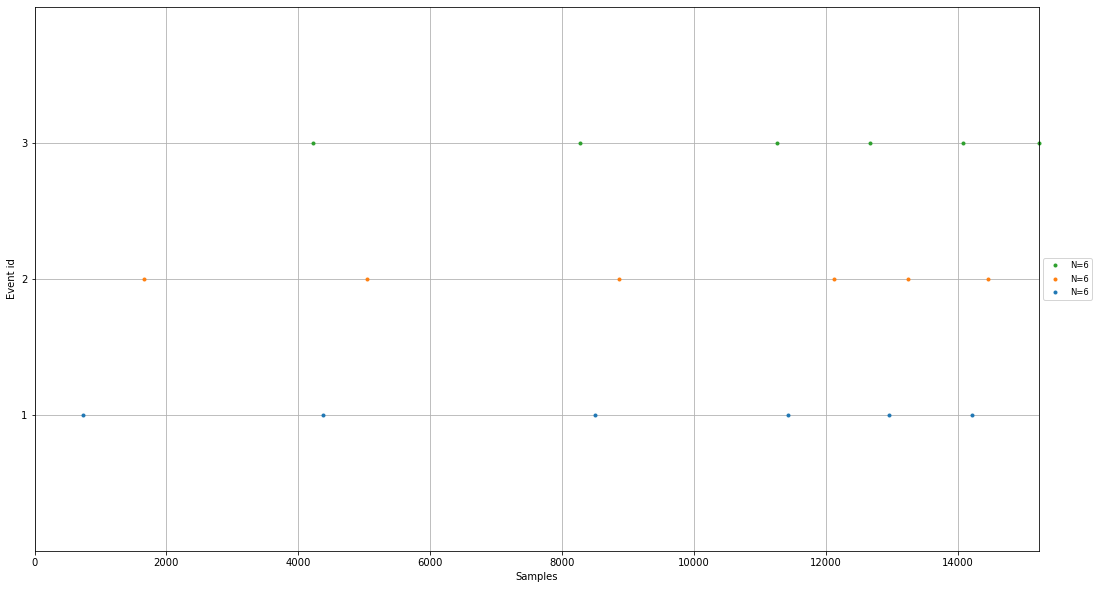

In [27]:
mne.viz.plot_events(events[:18]);

Not setting metadata
429 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 429 events and 91 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 20 events and 91 original time points ...


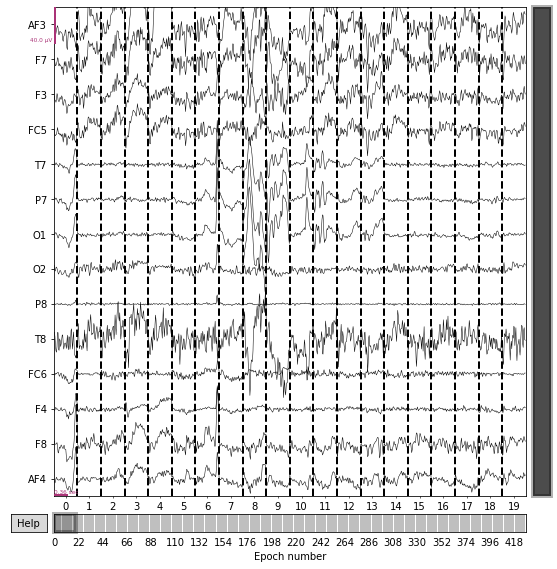

In [28]:
epochs = mne.Epochs(raw,events, event_id=event_ids)
epochs.plot();

In [29]:
epochs = mne.Epochs(raw,events, event_id=event_ids,preload=True)
epochs = ica.apply(epochs, exclude=ica.exclude)

Not setting metadata
429 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 429 events and 91 original time points ...
0 bad epochs dropped
Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 2 ICA components
    Projecting back using 14 PCA components


<ipython-input-29-278886a68ffe>:2: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  epochs = ica.apply(epochs, exclude=ica.exclude)


Not setting metadata
143 matching events found
No baseline correction applied
0 projection items activated


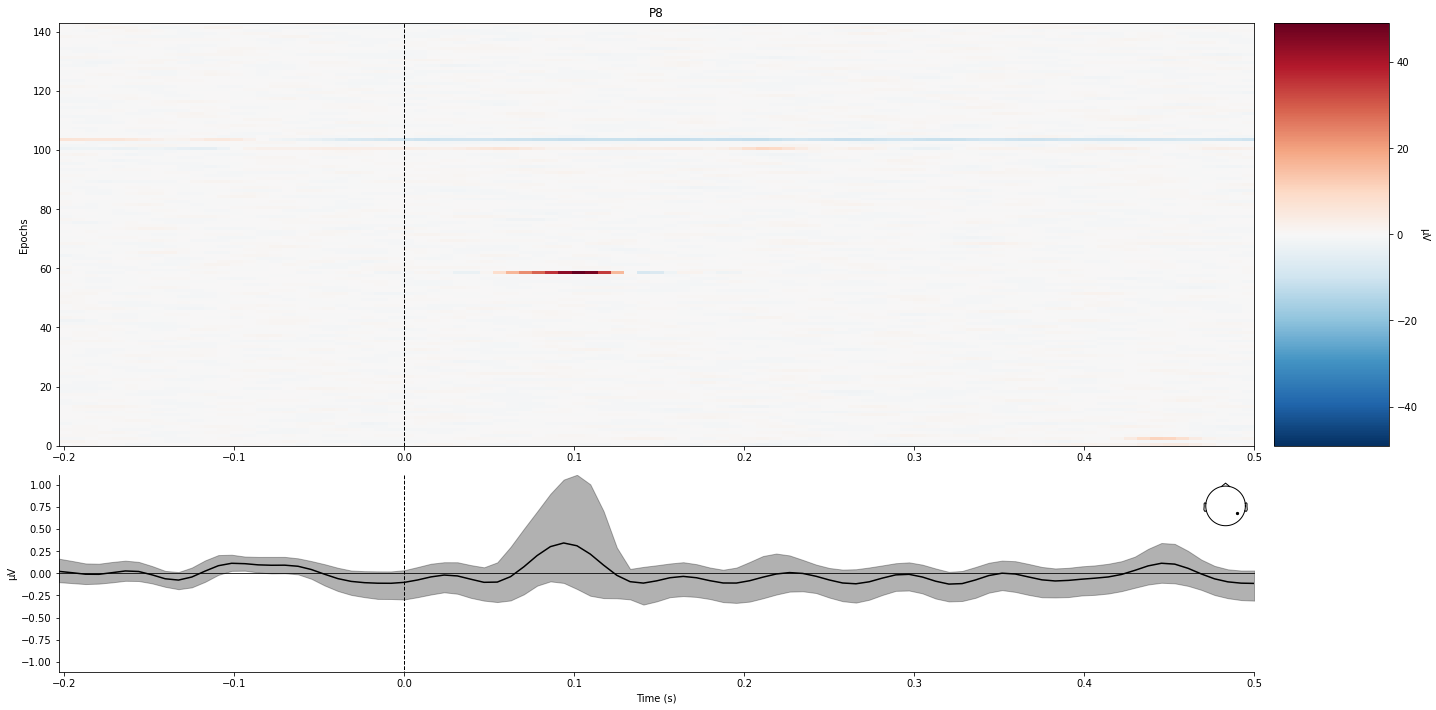

In [30]:
epochs["target"].plot_image(picks=[8]);

In [31]:
epochs.save("trial.fif",overwrite=True)

Overwriting existing file.


<ipython-input-31-11061d527762>:1: RuntimeWarning: This filename (trial.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save("trial.fif",overwrite=True)


In [32]:
#defining the duration of each epochs
epochs_for_tfr = mne.Epochs(raw,events,event_id=event_ids,
                           tmin=-.5,tmax=1.5,preload=True)

Not setting metadata
429 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 429 events and 257 original time points ...
0 bad epochs dropped


In [33]:
epochs_for_tfr = ica.apply(epochs_for_tfr,exclude=ica.exclude)
epochs_for_tfr.equalize_event_counts(event_ids);
epochs_for_tfr.save("trial-long.fif",overwrite=True)

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 2 ICA components
    Projecting back using 14 PCA components
Dropped 0 epochs: 
Overwriting existing file.


<ipython-input-33-2e0ac874d7a3>:1: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  epochs_for_tfr = ica.apply(epochs_for_tfr,exclude=ica.exclude)
<ipython-input-33-2e0ac874d7a3>:3: RuntimeWarning: This filename (trial-long.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_for_tfr.save("trial-long.fif",overwrite=True)


In [34]:
x = epochs.get_data()

In [35]:
x.shape # no. observations, Channels + events , time points

(429, 15, 91)

*Visualization and Time frequency analysis*

In [36]:
# segmented dataset
fname = "trial.fif"
epochs = mne.read_epochs(fname)

Reading C:\Users\User\Desktop\queenmary\MSc Thesis\thesis\MSc Thesis Supporting Materials - 210806991\trial.fif ...
    Found the data of interest:
        t =    -203.12 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata


<ipython-input-36-74d3cb7f6f1e>:3: RuntimeWarning: This filename (trial.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(fname)


429 matching events found
No baseline correction applied
0 projection items activated


In [37]:
epochs

Number of events,429
Events,resting: 143standard/writing: 143target/listening: 143
Time range,-0.203 – 0.500 sec
Baseline,-0.203 – 0.000 sec


*Evoked*

In [38]:
target = epochs["target"].average()
target

<Evoked | 'target/listening' (average, N=143), -0.20312 – 0.5 sec, baseline -0.203125 – 0 sec, 14 ch, ~37 kB>

In [39]:
standard = epochs["standard"].average()
standard

<Evoked | 'standard/writing' (average, N=143), -0.20312 – 0.5 sec, baseline -0.203125 – 0 sec, 14 ch, ~37 kB>

In [40]:
epochs.get_data().shape

(429, 15, 91)

In [41]:
epochs['target'].get_data().shape

(143, 15, 91)

In [42]:
target.data.shape

(14, 91)

In [43]:
target.info

<Info | 10 non-empty values
 bads: []
 ch_names: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4
 chs: 14 EEG
 custom_ref_applied: False
 dig: 17 items (3 Cardinal, 14 EEG)
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 lowpass: 20.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 14
 projs: []
 sfreq: 128.0 Hz
>

In [44]:
target.info['ch_names']

['AF3',
 'F7',
 'F3',
 'FC5',
 'T7',
 'P7',
 'O1',
 'O2',
 'P8',
 'T8',
 'FC6',
 'F4',
 'F8',
 'AF4']

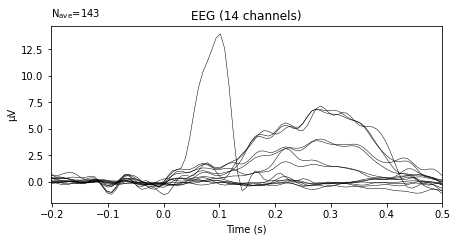

In [45]:
target.plot(); #average ERP 143 trials

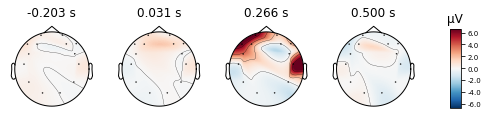

In [46]:
target.plot_topomap();

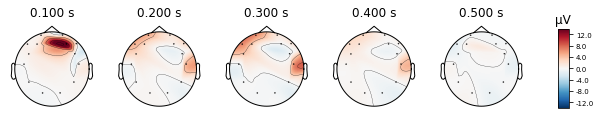

In [47]:
target.plot_topomap(times = [0.1,0.2,0.3,0.4,0.5]);

No projector specified for this dataset. Please consider the method self.add_proj.


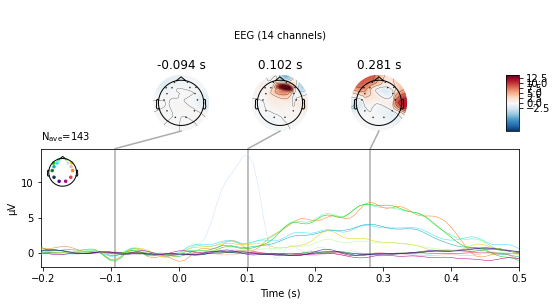

In [48]:
target.plot_joint();

No projector specified for this dataset. Please consider the method self.add_proj.


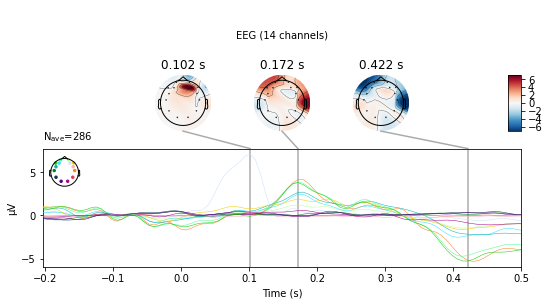

In [49]:
diff = mne.combine_evoked((target, -standard), weights='equal')
diff.plot_joint();

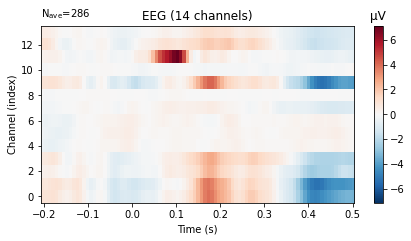

In [50]:
diff.plot_image();

In [51]:
rois = mne.channels.make_1020_channel_selections(diff.info, midline="z12")

In [52]:
# finding region of interestx
rois

{'Left': array([5, 4, 3, 1, 2, 0]),
 'Midline': array([6, 7]),
 'Right': array([ 8,  9, 10, 11, 12, 13])}

In [53]:
diff.plot_image(group_by=rois, show=False, show_names="all")

[<Figure size 1440x720 with 2 Axes>,
 <Figure size 1440x720 with 2 Axes>,
 <Figure size 1440x720 with 2 Axes>]

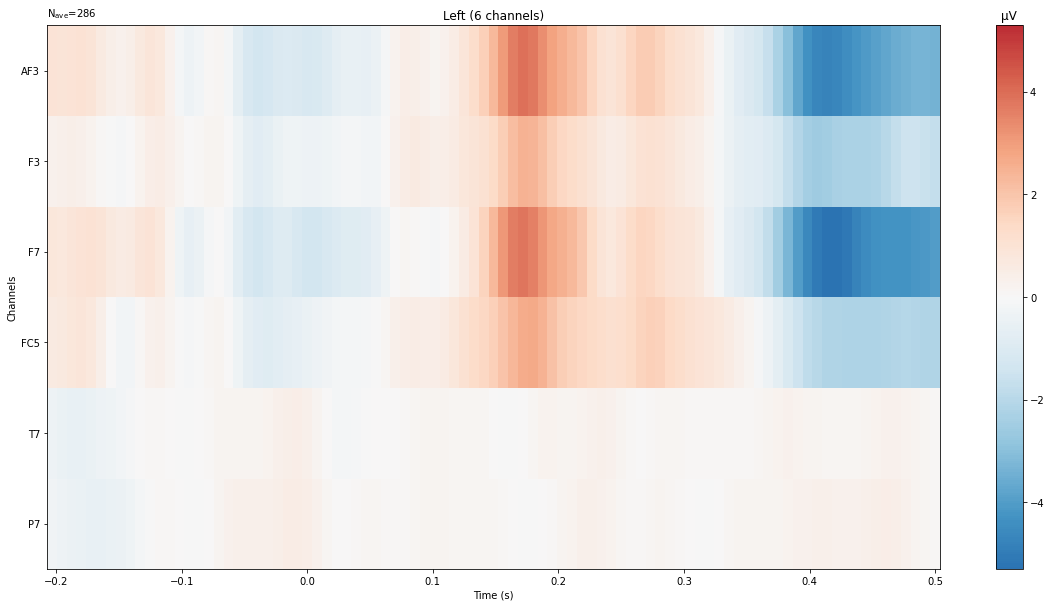

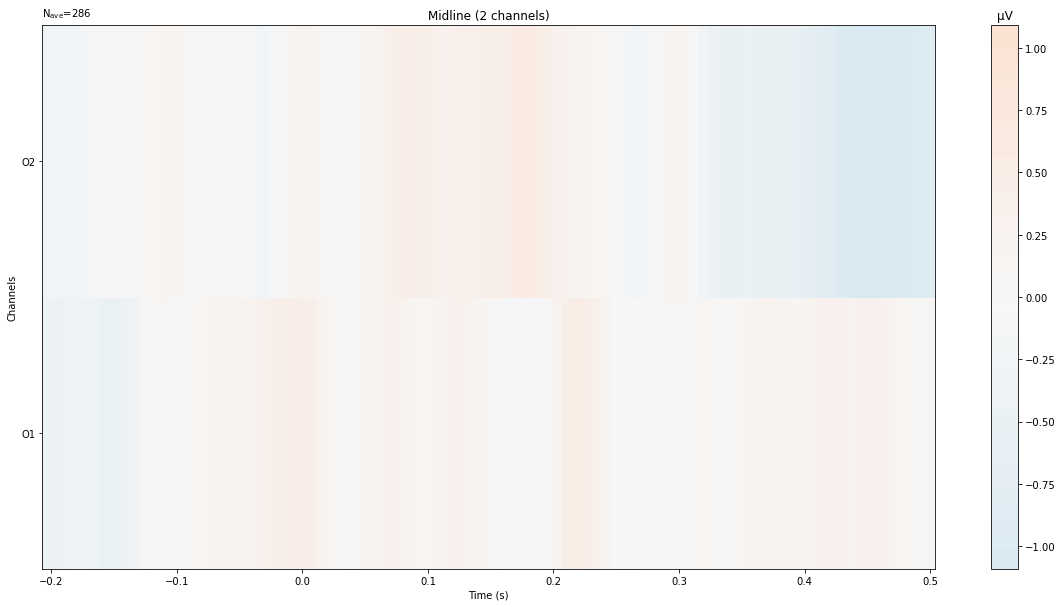

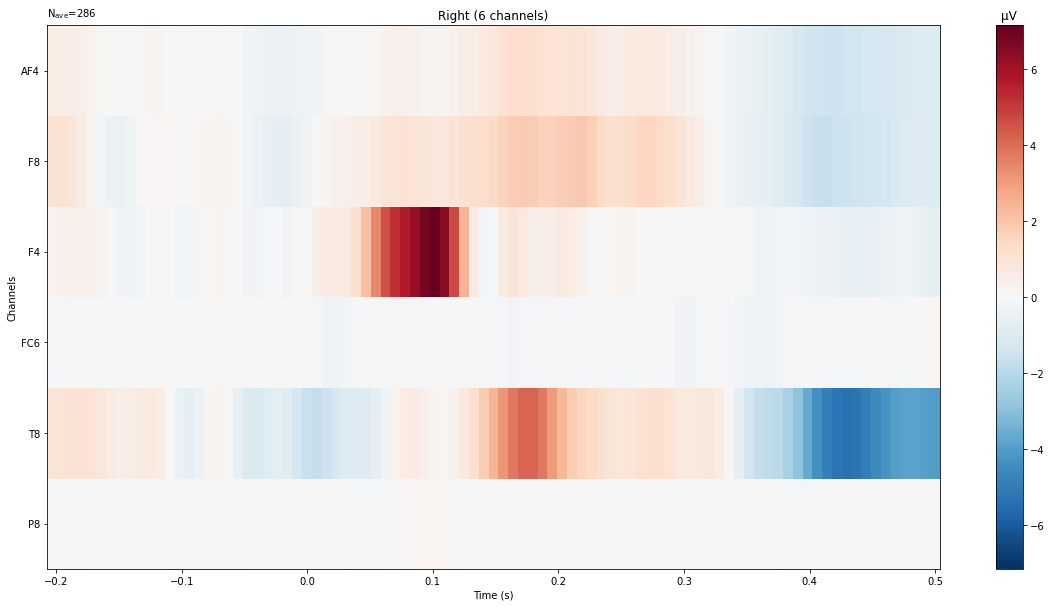

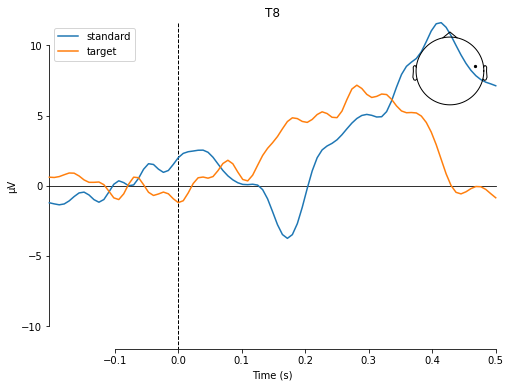

In [54]:
mne.viz.plot_compare_evokeds({"standard":standard,
                             "target":target}, picks=[9]);

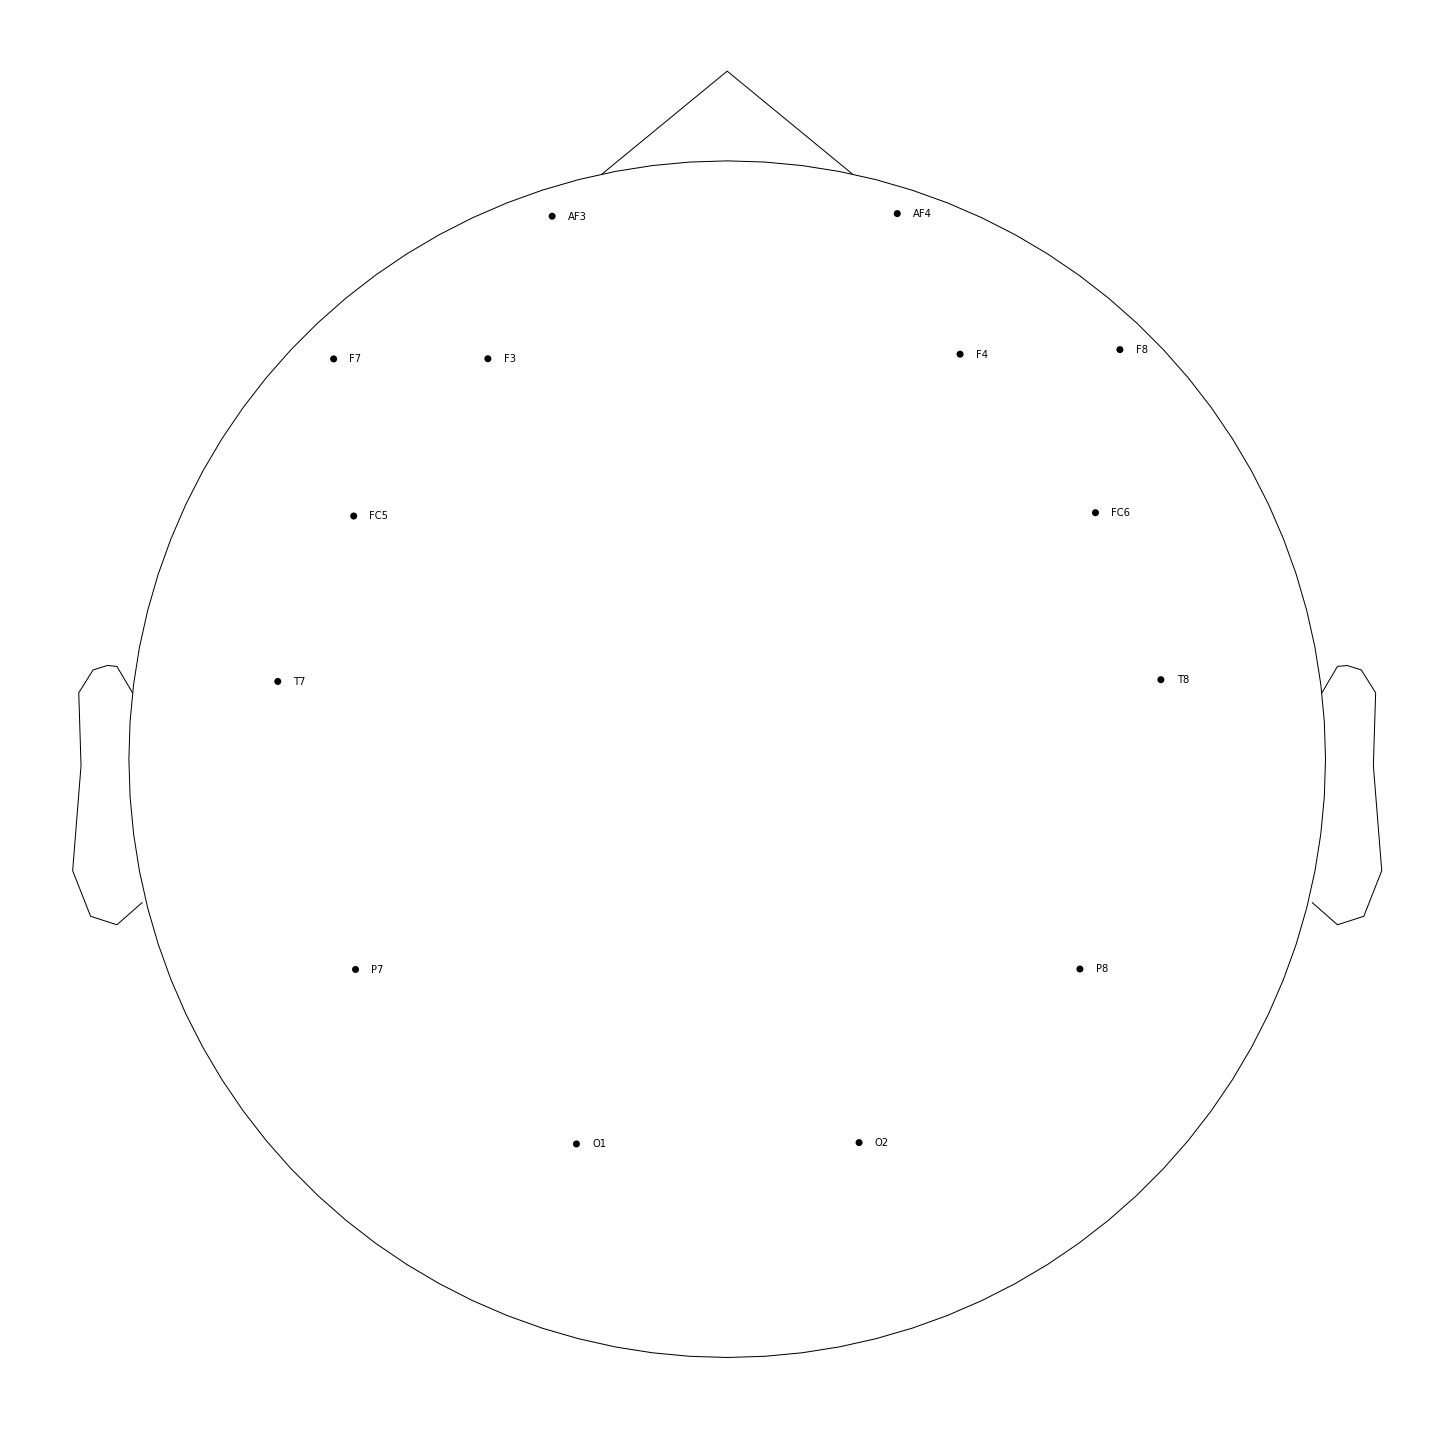

In [55]:
target.plot_sensors(show_names=True);

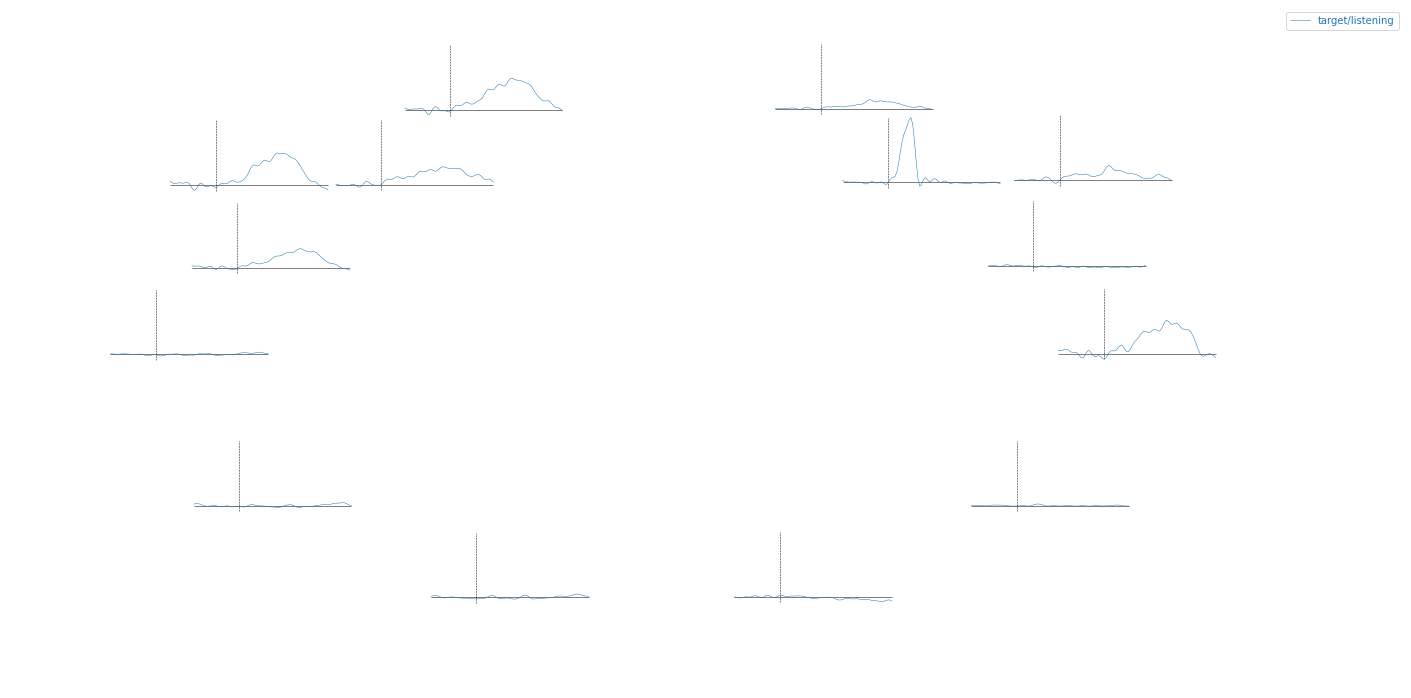

In [56]:
target.plot_topo();

In [57]:
target.data

array([[ 4.43381848e-07,  2.49042068e-07,  1.12504796e-07, ...,
         4.21233978e-07,  1.73634626e-07, -2.44766903e-07],
       [ 8.16144706e-07,  5.00397418e-07,  3.07221920e-07, ...,
        -6.33079553e-07, -7.90183648e-07, -1.09184466e-06],
       [ 4.99581555e-08,  3.36111890e-08, -5.07015807e-08, ...,
         1.21838902e-06,  9.77409791e-07,  5.90541602e-07],
       ...,
       [ 3.41280548e-07,  3.11857961e-07,  1.99568946e-07, ...,
        -3.86399690e-08, -1.49553527e-07, -2.38914028e-07],
       [-1.76957783e-07, -9.79447444e-08, -3.57210119e-08, ...,
         3.76028329e-07,  1.16128948e-07, -2.09770937e-07],
       [ 7.23140980e-09, -1.82617318e-08, -2.95839002e-08, ...,
        -1.07827432e-08, -1.16212215e-07, -2.86891921e-07]])

In [58]:
x = target.data

In [59]:
channel = 'T8'
chIndex = [i for i, j in enumerate(ch_names) if j ==channel]

In [60]:
plt.plot(x[chIndex[0],:])
plt.title(channel)
plt.ylabel("Amplitude")
plt.xlabel('Time Samples')

Text(0.5, 0, 'Time Samples')

*Time-frequency - Power Spectral density*

In [61]:
epochs_for_tfr = mne.read_epochs("trial-long.fif")

Reading C:\Users\User\Desktop\queenmary\MSc Thesis\thesis\MSc Thesis Supporting Materials - 210806991\trial-long.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-61-2690ab8f8572>:1: RuntimeWarning: This filename (trial-long.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_for_tfr = mne.read_epochs("trial-long.fif")


Effective window size : 16.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


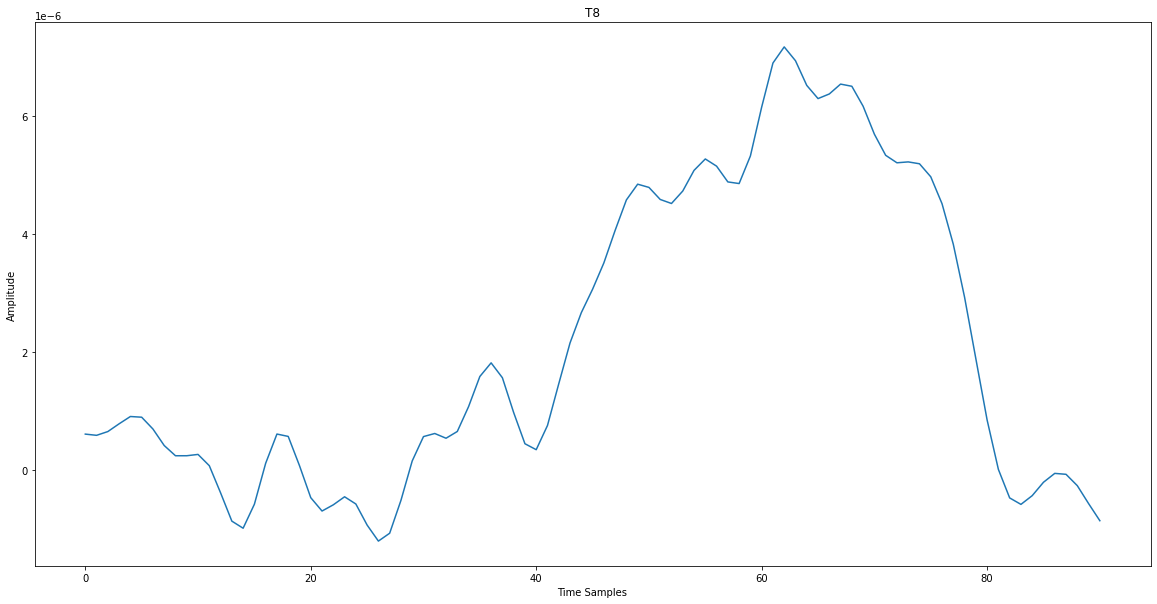

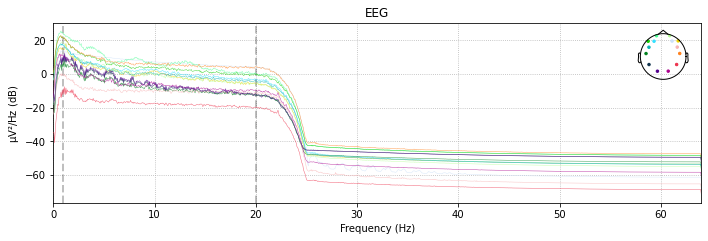

In [62]:
raw.plot_psd();

    Using multitaper spectrum estimation with 7 DPSS windows


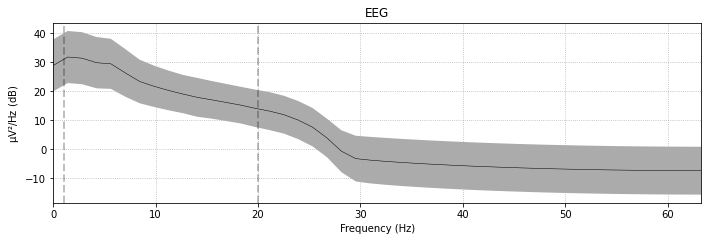

In [63]:
epochs.plot_psd(average=True);

    Using multitaper spectrum estimation with 7 DPSS windows


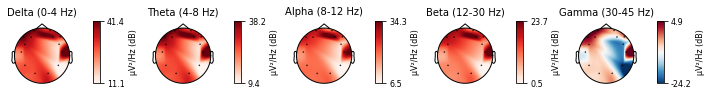

In [64]:
epochs.plot_psd_topomap(ch_type='eeg', normalize=False);

Effective window size : 0.625 (s)
Effective window size : 2.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


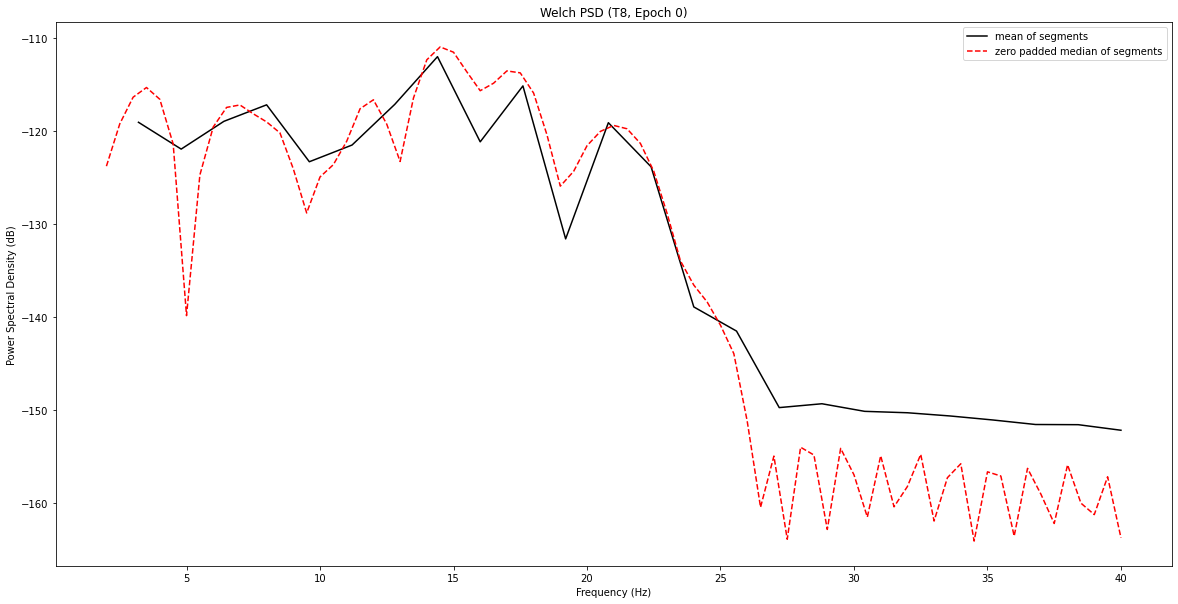

<Figure size 720x720 with 0 Axes>

In [65]:
kwargs = dict(fmin=2, fmax=40, n_jobs=None)
psds_welch_mean, freqs_mean = psd_welch(epochs, average='mean', **kwargs,n_fft=80)
psds_welch_zero, freqs_zero = psd_welch(epochs, average='median', **kwargs,n_per_seg=100)

# Convert power to dB scale.
psds_welch_mean = 10 * np.log10(psds_welch_mean)
psds_welch_zero = 10 * np.log10(psds_welch_zero)

# We will only plot the PSD for a single sensor in the first epoch.
ch_name = 'T8'
ch_idx = epochs.info['ch_names'].index(ch_name)
epo_idx = 0

_, ax = plt.subplots()
ax.plot(freqs_mean, psds_welch_mean[epo_idx, ch_idx, :], color='k',
        ls='-', label='mean of segments')
ax.plot(freqs_zero, psds_welch_zero[epo_idx, ch_idx, :], color='r',
        ls='--', label='zero padded median of segments')

ax.set(title='Welch PSD ({}, Epoch {})'.format(ch_name, epo_idx),
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='upper right')
plt.figure(figsize=(10, 10))
plt.show()

In [66]:
psds_welch_unagg, freqs_unagg = psd_welch(epochs, average=None, **kwargs,n_fft=91)
# dimensions are (n_epochs, n_sensors, n_freqs, n_segments)
print(psds_welch_unagg.shape)

Effective window size : 0.711 (s)
(429, 14, 27, 1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Using multitaper spectrum estimation with 7 DPSS windows


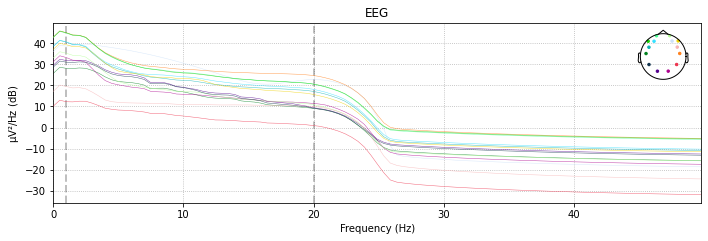

In [67]:
epochs_for_tfr.plot_psd(fmin=0, fmax=50);

In [68]:
freqs = list(range(3,30))
tfr_target = tfr_morlet(epochs_for_tfr["target"], freqs, 3, return_itc=False)
tfr_standard = tfr_morlet(epochs_for_tfr["standard"], freqs, 3, return_itc=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.0s finished


In [69]:
tfr_target.data.shape # channel, freq range, time samples

(14, 27, 257)

In [70]:
tfr_contrast = mne.combine_evoked((tfr_standard, tfr_target),(-.5,.5))
tfr_contrast.apply_baseline((None,0))

Applying baseline correction (mode: mean)


<AverageTFR | time : [-0.500000, 1.500000], freq : [3.000000, 29.000000], nave : 286, channels : 14, ~786 kB>

No baseline correction applied
No baseline correction applied


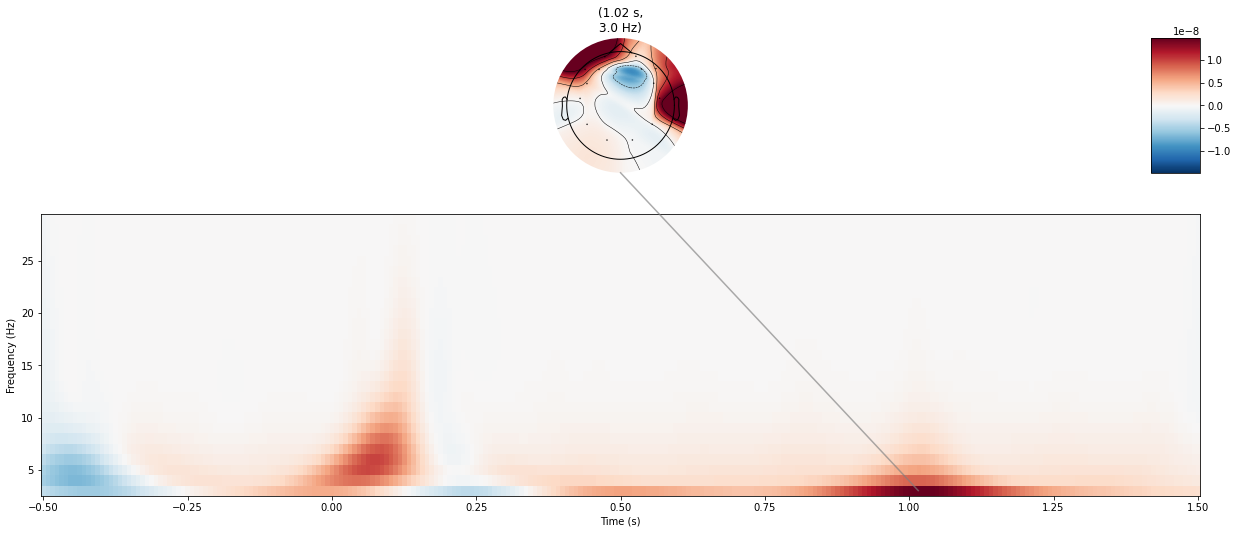

In [71]:
tfr_contrast.plot_joint();

No baseline correction applied


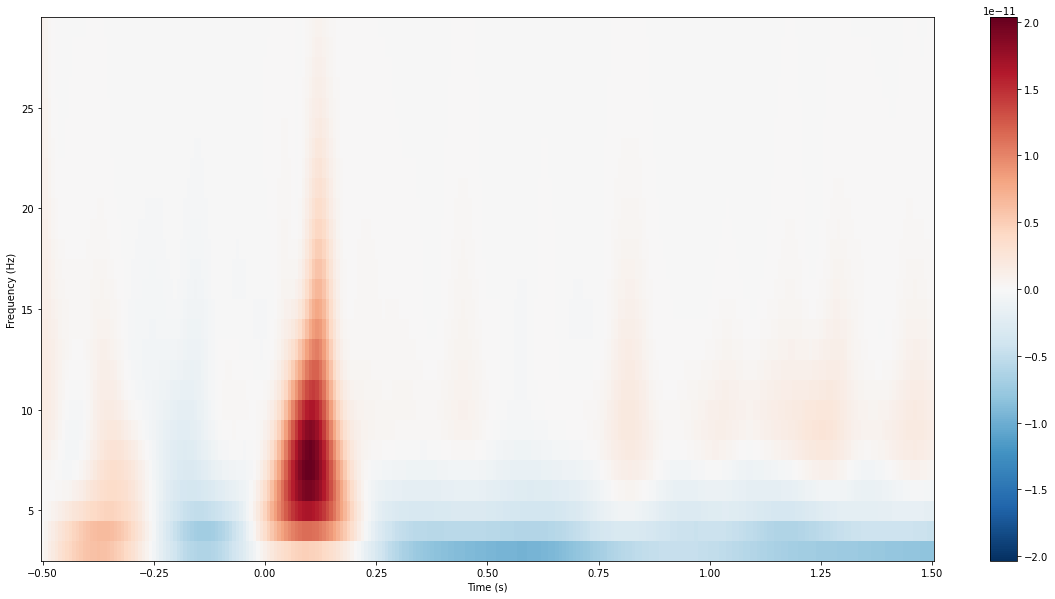

In [72]:
tfr_contrast.plot(picks=[8]);

*Frequency Bands*

In [73]:
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

In [74]:
tmin, tmax = -0.5, 0.5
baseline = None

# get the header to extract events
channel_list = raw.pick_types(eeg=True).ch_names

channel_frequency_list = list()
frequency_map = list()

for ch in channel_list:
    for band, fmin, fmax in iter_freqs:
        raw.pick_types(eeg = True)
        raw.load_data()

        # bandpass filter
        raw.filter(fmin, fmax, n_jobs=15,  # use more jobs to speed up
                   l_trans_bandwidth=1,  
                   h_trans_bandwidth=1)  

        # epoch
        epochs1 = mne.Epochs(raw, events, event_ids, tmin, tmax,
                            baseline=baseline,
                            preload=True)

        epochs1.pick_channels([ch])

        # remove evoked response
        epochs1.subtract_evoked()

        # get analytic signal (envelope)
        epochs1.apply_hilbert(envelope=True)
        frequency_map.append(((band, fmin, fmax), epochs1.average()))
    channel_frequency_list.append(frequency_map)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:   52.3s remaining:  3.2min
[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:   55.9s remaining:  1.2min
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:   57.4s remaining:   31.8s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:   59.0s remaining:    9.7s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...
0 bad epochs dropped
Subtracting Evoked from Epochs
[done]


[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:   59.7s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...
0 bad epochs dropped
Subtracting Evoked from Epochs
[done]


[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    9.2s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 25.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 45.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 25.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 45.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.8s
[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.3s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 25.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.3s finished


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...
0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 45.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.3s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.3s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.3s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 25.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 45.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.6s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.3s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 25.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 45.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.3s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.3s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.3s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 25.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 45.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.3s finished


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...
0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 25.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 45.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 25.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 45.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 25.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 45.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 25.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 45.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.3s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 25.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 45.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 25.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 45.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.3s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 25.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 45.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.1s remaining:    0.5s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 25.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 45.50 Hz)
- Filter length: 423 samples (3.305 sec)



[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   3 out of  14 | elapsed:    0.0s remaining:    0.4s


Not setting metadata
429 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 429 events and 129 original time points ...


[Parallel(n_jobs=15)]: Done   6 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=15)]: Done   9 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  12 out of  14 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  14 out of  14 | elapsed:    0.2s finished


0 bad epochs dropped
Subtracting Evoked from Epochs
[done]


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Text(0.5, 0, 'Time [ms]')

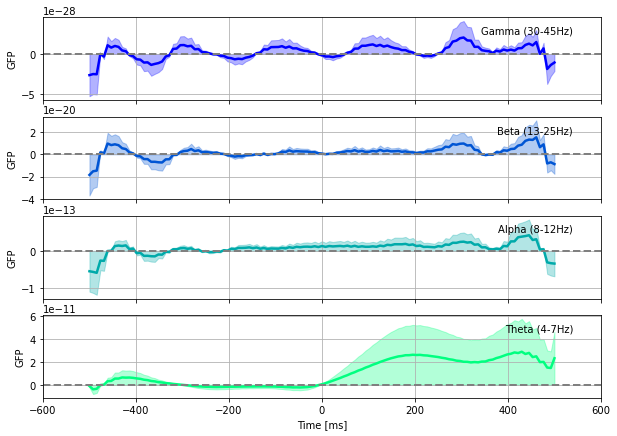

In [75]:
%matplotlib inline
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x ** 2, axis=0)

# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.data, random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-600, 600)

axes.ravel()[-1].set_xlabel('Time [ms]')

In [76]:
tmin, tmax = -0.5, 0.5

# Setup for reading the raw data 
raw.filter(.5, None, fir_design='firwin')
picks = mne.pick_types(raw.info, eeg=True)

# Read epochs
labels = epochs.events[:, -1]

# get EEG data
data = epochs.get_data()

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 845 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.2s finished


In [77]:
X_train,y_train, X_test,y_test = Subj.getXy_eeg(task=1,features='rhythmic',winsize=128, hopesize=32)

print('DataShape: ',X_train.shape,y_train.shape,X_test.shape, y_test.shape)
print('\nAttention levels:\n',np.unique(y_train))

# Round off around 10

y_train = 10*(y_train//10)
y_test = 10*(y_test//10)

print('\nNew Attention levels:\n',np.unique(y_train))

100%|##################################################|100\100|Sg - 0
Done..
100%|##################################################|43\43|Sg - 0
Done..
DataShape:  (624, 84) (624,) (252, 84) (252,)

Attention levels:
 [  0   7  12  14  15  18  20  22  25  28  33  37  38  42  44  45  46  50
  54  60  62  66  71  72  75  76  80  83  85  87  88 100]

New Attention levels:
 [  0  10  20  30  40  50  60  70  80 100]


In [78]:
L,W,R, Scores, Cols = Subj.getLWR()

# Listening Segmnts :  143
# Writing Segmnts   :  143
# Resting Segmnts   :  143
# Scores :  143


In [79]:
print(Scores)

[100.0, 44.4444444444, 100.0, 0.0, 50.0, 100.0, 50.0, 0.0, 25.0, 50.0, 50.0, 88.8888888889, 100.0, 100.0, 100.0, 37.5, 45.4545454545, 38.4615384615, 75.0, 100.0, 100.0, 50.0, 20.0, 72.72727272729999, 100.0, 100.0, 100.0, 71.4285714286, 100.0, 100.0, 100.0, 71.4285714286, 75.0, 76.9230769231, 100.0, 0.0, 18.1818181818, 12.5, 33.3333333333, 100.0, 100.0, 66.6666666667, 100.0, 83.3333333333, 85.7142857143, 75.0, 85.7142857143, 87.5, 75.0, 100.0, 0.0, 0.0, 0.0, 22.2222222222, 100.0, 100.0, 100.0, 100.0, 100.0, 25.0, 100.0, 25.0, 80.0, 28.5714285714, 46.1538461538, 100.0, 100.0, 38.4615384615, 100.0, 76.9230769231, 75.0, 14.2857142857, 87.5, 54.5454545455, 60.0, 15.3846153846, 25.0, 100.0, 0.0, 75.0, 100.0, 7.6923076923, 100.0, 100.0, 100.0, 42.8571428571, 25.0, 100.0, 0.0, 100.0, 100.0, 42.8571428571, 60.0, 75.0, 75.0, 100.0, 62.5, 25.0, 0.0, 0.0, 58.3333333333, 0.0, 100.0, 100.0, 54.5454545455, 41.6666666667, 0.0, 100.0, 100.0, 100.0, 0.0, 100.0, 100.0, 66.6666666667, 50.0, 100.0, 100.0, 

In [80]:
scores = [np.round(10*(x//10)) for x in Scores]
scores = list(map(int, scores))
scores

[100,
 40,
 100,
 0,
 50,
 100,
 50,
 0,
 20,
 50,
 50,
 80,
 100,
 100,
 100,
 30,
 40,
 30,
 70,
 100,
 100,
 50,
 20,
 70,
 100,
 100,
 100,
 70,
 100,
 100,
 100,
 70,
 70,
 70,
 100,
 0,
 10,
 10,
 30,
 100,
 100,
 60,
 100,
 80,
 80,
 70,
 80,
 80,
 70,
 100,
 0,
 0,
 0,
 20,
 100,
 100,
 100,
 100,
 100,
 20,
 100,
 20,
 80,
 20,
 40,
 100,
 100,
 30,
 100,
 70,
 70,
 10,
 80,
 50,
 60,
 10,
 20,
 100,
 0,
 70,
 100,
 0,
 100,
 100,
 100,
 40,
 20,
 100,
 0,
 100,
 100,
 40,
 60,
 70,
 70,
 100,
 60,
 20,
 0,
 0,
 50,
 0,
 100,
 100,
 50,
 40,
 0,
 100,
 100,
 100,
 0,
 100,
 100,
 60,
 50,
 100,
 100,
 60,
 40,
 60,
 0,
 100,
 100,
 0,
 30,
 40,
 80,
 30,
 100,
 100,
 100,
 100,
 100,
 10,
 80,
 30,
 0,
 80,
 100,
 100,
 100,
 70,
 100]

In [81]:
# Normalization - SVM works well with normalized features
means = X_train.mean(0)
std   = X_train.std(0)
X_train = (X_train-means)/std
X_test  = (X_test-means)/std


# Training
clf = svm.SVR(kernel='rbf', C=1,gamma='auto')
clf.fit(X_train,y_train)

# Predition
ytp = clf.predict(X_train)
ysp = clf.predict(X_test)

# Evaluation
T1_tre =  np.mean(np.abs(y_train-ytp))
T1_tse =  np.mean(np.abs(y_test-ysp))
print('Training MAE:',T1_tre)
print('Testing  MAE:',T1_tse)

Training MAE: 28.760682598276606
Testing  MAE: 31.862724647034558


In [82]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lr', LogisticRegression(random_state=42, solver='lbfgs'))])
y = labels

In [83]:
selected_funcs = {'mean', 'ptp_amp', 'std','rms','zero_crossings'}
X_new = extract_features(data, raw.info['sfreq'], selected_funcs)
kf = KFold(n_splits=3, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X_new, y, scoring='accuracy', cv=kf)

In [84]:
print('Cross-validation accuracy score = %1.3f (+/- %1.5f)' % (np.mean(scores),
                                                               np.std(scores)))

Cross-validation accuracy score = 0.993 (+/- 0.00571)


In [85]:
def compute_medfilt(arr):
    """Median filtered signal as features.

    Parameters
    ----------
    arr : ndarray, shape (n_channels, n_times)

    Returns
    -------
    output : (n_channels * n_times,)
    """
    return medfilt(arr, kernel_size=(1, 5)).ravel()

In [86]:
selected_funcs = [('medfilt', compute_medfilt),'mean']

pipe = Pipeline([('fe', FeatureExtractor(sfreq=raw.info['sfreq'],
                                         selected_funcs=selected_funcs)),
                 ('scaler', StandardScaler()),
                 ('clf', LogisticRegression(random_state=42, solver='lbfgs',max_iter=1000))])
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
y = labels

In [87]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)
accuracy = pipe.fit(X_train, y_train).score(X_test, y_test)
print('Accuracy score = %1.3f' % accuracy)

Accuracy score = 0.965


In [88]:
print('DataShape: ',X_train.shape,y_train.shape,X_test.shape, y_test.shape)
print('\nClass labels :',np.unique(y_train))

DataShape:  (343, 15, 91) (343,) (86, 15, 91) (86,)

Class labels : [1 2 3]


In [89]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))
nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [90]:
print('DataShape: ',X_train.shape,y_train.shape,X_test.shape, y_test.shape)

DataShape:  (343, 1365) (343,) (86, 1365) (86,)


In [91]:
means = X_train.mean(0)
std   = X_train.std(0)
X_train = (X_train-means)/std
X_test  = (X_test-means)/std

In [92]:
# Training
clf = svm.SVC(kernel='rbf', C=1,gamma='auto')
clf.fit(X_train,y_train)

# Predition
ytp = clf.predict(X_train)
ysp = clf.predict(X_test)

# Evaluation
T4_trac =  np.mean(y_train==ytp)
T4_tsac =  np.mean(y_test==ysp)
print('Training Accuracy:',T4_trac)
print('Testing  Accuracy:',T4_tsac)

Training Accuracy: 1.0
Testing  Accuracy: 0.9651162790697675


In [93]:
steps = [('scaler', StandardScaler()), ('SVM', SVC())]
pipeline = Pipeline(steps)
parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
grid.fit(X_train, y_train)
print ("score = %3.2f" %(grid.score(X_test,y_test)))
print (grid.best_params_)

score = 0.90
{'SVM__C': 10, 'SVM__gamma': 0.01}


In [94]:
pipeline.named_steps

{'scaler': StandardScaler(), 'SVM': SVC()}

In [95]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [96]:
lda = LDA(n_components=1)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

In [97]:
classifier = RandomForestClassifier(max_depth=2, random_state=0)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [98]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_test, y_pred)))

[[32  0  0]
 [ 0 26  0]
 [ 0  0 28]]
Accuracy1.0
